June: Creating flux containers/planes and looking at scaling factors.

In [2]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import xarray as xr
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles
import functions_upwelling_depth

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

from operator import itemgetter 

# Load Bathymetry and Mesh

In [37]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/Resolution_237_177_80/Run01/'
with nc.Dataset(os.path.join(path, 'mesh_mask.nc'), 'r') as nbl:
    gdepw_1d = nbl.variables['gdepw_1d'][0,...]
    gdepw_0 = nbl.variables['gdepw_0'][0,...]
    gdepu = nbl.variables['gdepu'][0,...]
    gdepv = nbl.variables['gdepv'][0,...]
    e3t_1d = nbl.variables['e3t_1d'][0,...]
    e3t_0 = nbl.variables['e3t_0'][0,...]
    e3w_1d = nbl.variables['e3w_1d'][0,...]
    e3w_0 = nbl.variables['e3w_0'][0,...]
    e3u_0 = nbl.variables['e3u_0'][0,...]
    e3v_0 = nbl.variables['e3v_0'][0,...]
    e1v = nbl.variables['e1v'][0,...]
    e1u = nbl.variables['e1u'][0,...]
    e2u = nbl.variables['e2u'][0,...]
    e1t = nbl.variables['e1t'][0,...]
    umask = nbl.variables['umask'][0,...]
    tmask = nbl.variables['tmask'][0,...]
    mbathy = nbl.variables['mbathy'][0,...]

In [ ]:
def define_vertical_fluxplanes(bathy_plane):
    
    # depth closest to the bottom of the canyon
    depth_canyon_approx = bathy_plane.max()
    
    # canyon axis
    ind_axis = np.where(bathy_plane == depth_canyon_approx)[0][0]
    
    # finding the potential rim points
    slope = abs(np.diff(bathy_plane))
    ind_rimL0 = np.where(slope > 0.01)[0][0]
    ind_rimR0 = np.where(slope > 0.01)[0][-1]
    
    # index of the actual rim points
    width_shelf = max(ind_rimR0 - ind_axis, ind_axis - ind_rimL0)
    ind_rimL = ind_axis - width_shelf
    ind_rimR = ind_axis + width_shelf
    
    # adjacent containers with the same width
    ind_shfL = ind_rimL - width_shelf
    ind_shfR = ind_rimR + width_shelf
    
    return ind_axis, ind_rimL, ind_rimR, ind_shfL, ind_shfR

In [51]:
def calculate_area_allcells(e1v, e3v_0, e2u, e3u_0, ind_plane, tmask):
    '''Calculates the areas of all wet and partial wet cells.'''
    
    mask_plane = tmask[:,ind_plane,:]

    cell_x_j = e1v[ind_plane, :]
    cell_y_j = e3v_0[:,ind_plane,:]
    area_j = mask_plane * cell_x_j * cell_y_j

    cell_x_i = e2u[ind_plane, :]
    cell_y_i = e3u_0[:,ind_plane,:]
    area_i = mask_plane * cell_x_i * cell_y_i
    
    return area_j, area_i, mask_plane

In [ ]:
ind_plane = np.argmin(np.abs(bathy[:,0] - depth_shelf))
bathy_plane = bathy[ind_plane,:]

In [54]:
def define_horizontal_fluxplanes(bathy, gdepw_1d, this_area):
    
    # depth closest to the shelf depth
    depth_shelf_approx = 80
    ind_shelf = np.argmin(np.abs(gdepw_1d - depth_shelf_approx))
    depth_shelf = gdepw_1d[ind_shelf]
    
    # ind and depth closest to the canyon bottom
    depth_canyon_approx = bathy_plane.max()
    ind_canyon = np.argmin(np.abs(gdepw_1d - depth_canyon_approx))
    depth_canyon = gdepw_1d[ind_canyon]

    # get mid way plane
    area_all = np.zeros(this_area.shape[0])
    for depth_ind in range(this_area.shape[0]):
        area_row = this_area[depth_ind,:].sum()
        area_all[depth_ind] = area_row

    area_canyon = area_all[ind_shelf:ind_canyon]
    area_canyon_inds = np.arange(ind_shelf,ind_canyon)

    total_area_canyon = np.sum(area_canyon)
    half_area_canyon = total_area_canyon / 2
    cumsum_area_canyon = np.cumsum(area_canyon)
    half_area_canyon_ind = (np.abs(cumsum_area_canyon-half_area_canyon)).argmin()
    ind_half = area_canyon_inds[half_area_canyon_ind]
    depth_half = gdepw_1d[ind_half]

    sum_area_plane = np.sum(area_all)
    sum_area_over_break = np.sum(area_all[:ind_shelf])
    sum_area_top_half = np.sum(area_all[ind_shelf:ind_area_half+1])
    sum_area_bot_half = np.sum(area_all[ind_area_half+1:])
    
    return ind_shelf, depth_shelf, ind_canyon, depth_canyon, ind_half, depth_half

# Shelf Break Plane

In [43]:
ind_plane, bathy_plane = get_shelfbreak_plane(bathy, gdepw_1d)

<a list of 1 text.Text objects>

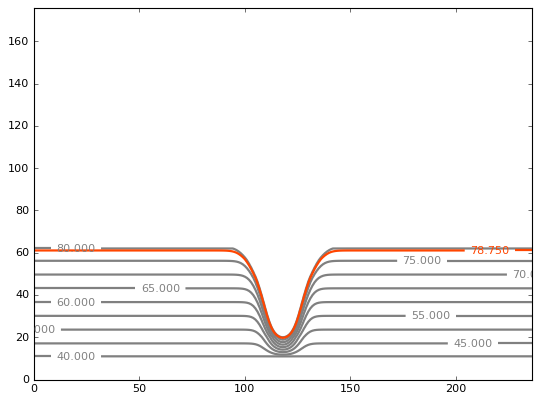

In [45]:
fig, ax = plt.subplots(1,1,figsize=(bathy.shape[1]/bathy.shape[0]*6, 6))
c = ax.contour(bathy[:,:], levels = np.arange(40,85,5), colors='gray', linewidths=2)
c1 = ax.contour(bathy[:,:], levels = [depth_shelf], colors='orangered', linewidths=2)
ax.clabel(c, inline=1, fontsize=10)
ax.clabel(c1, inline=1, fontsize=10)

# Vertical Planes

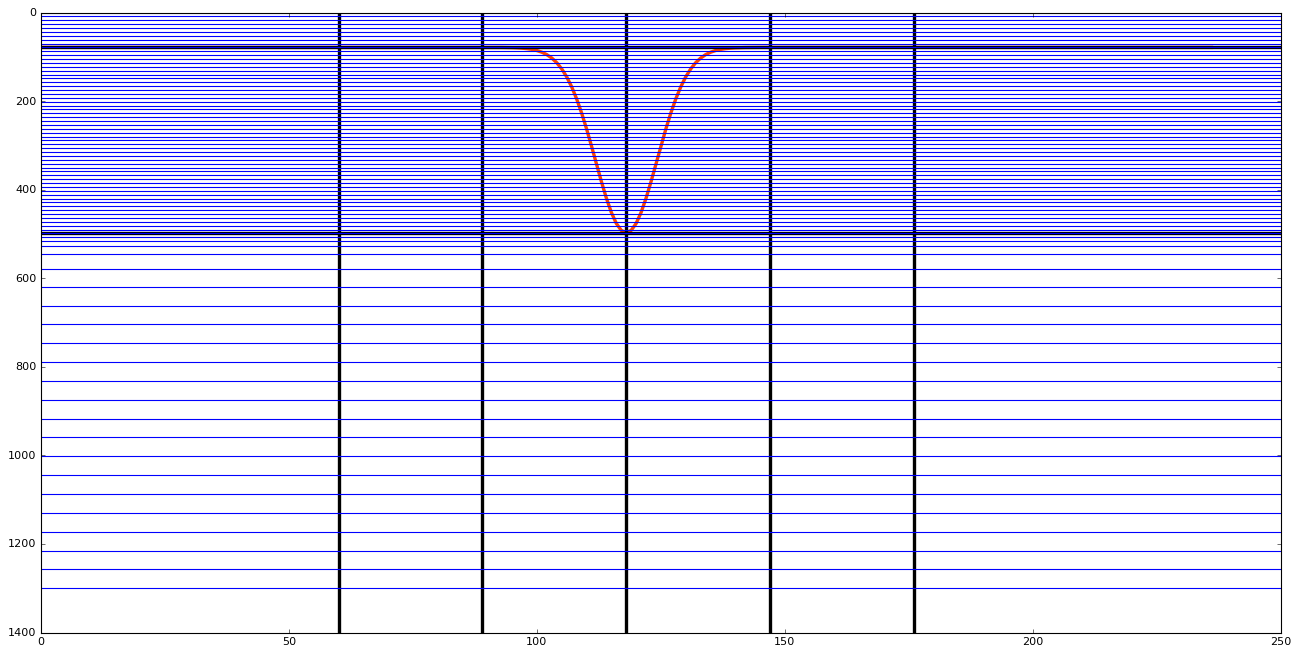

In [7]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(bathy_plane, lw=3, c='orangered')
ax.invert_yaxis()

lw, c = 3, 'k'

ax.axhline(depth_shelf, c=c, lw=lw)
ax.axhline(depth_canyon, c=c, lw=lw)

ax.axvline(ind_axis, c=c, lw=lw)
ax.axvline(ind_rimL, c=c, lw=lw)
ax.axvline(ind_rimR, c=c, lw=lw)
ax.axvline(ind_shfL, c=c, lw=lw)
ax.axvline(ind_shfR, c=c, lw=lw)

for gdepw in zip(gdepw_1d):
    ax.axhline(gdepw, c='b', label = 'gdepw')

# Areas for Flux

In [52]:
area_j, area_i, mask_plane = calculate_area_allcells(e1v, e3v_0, e2u, e3u_0, ind_plane, tmask)

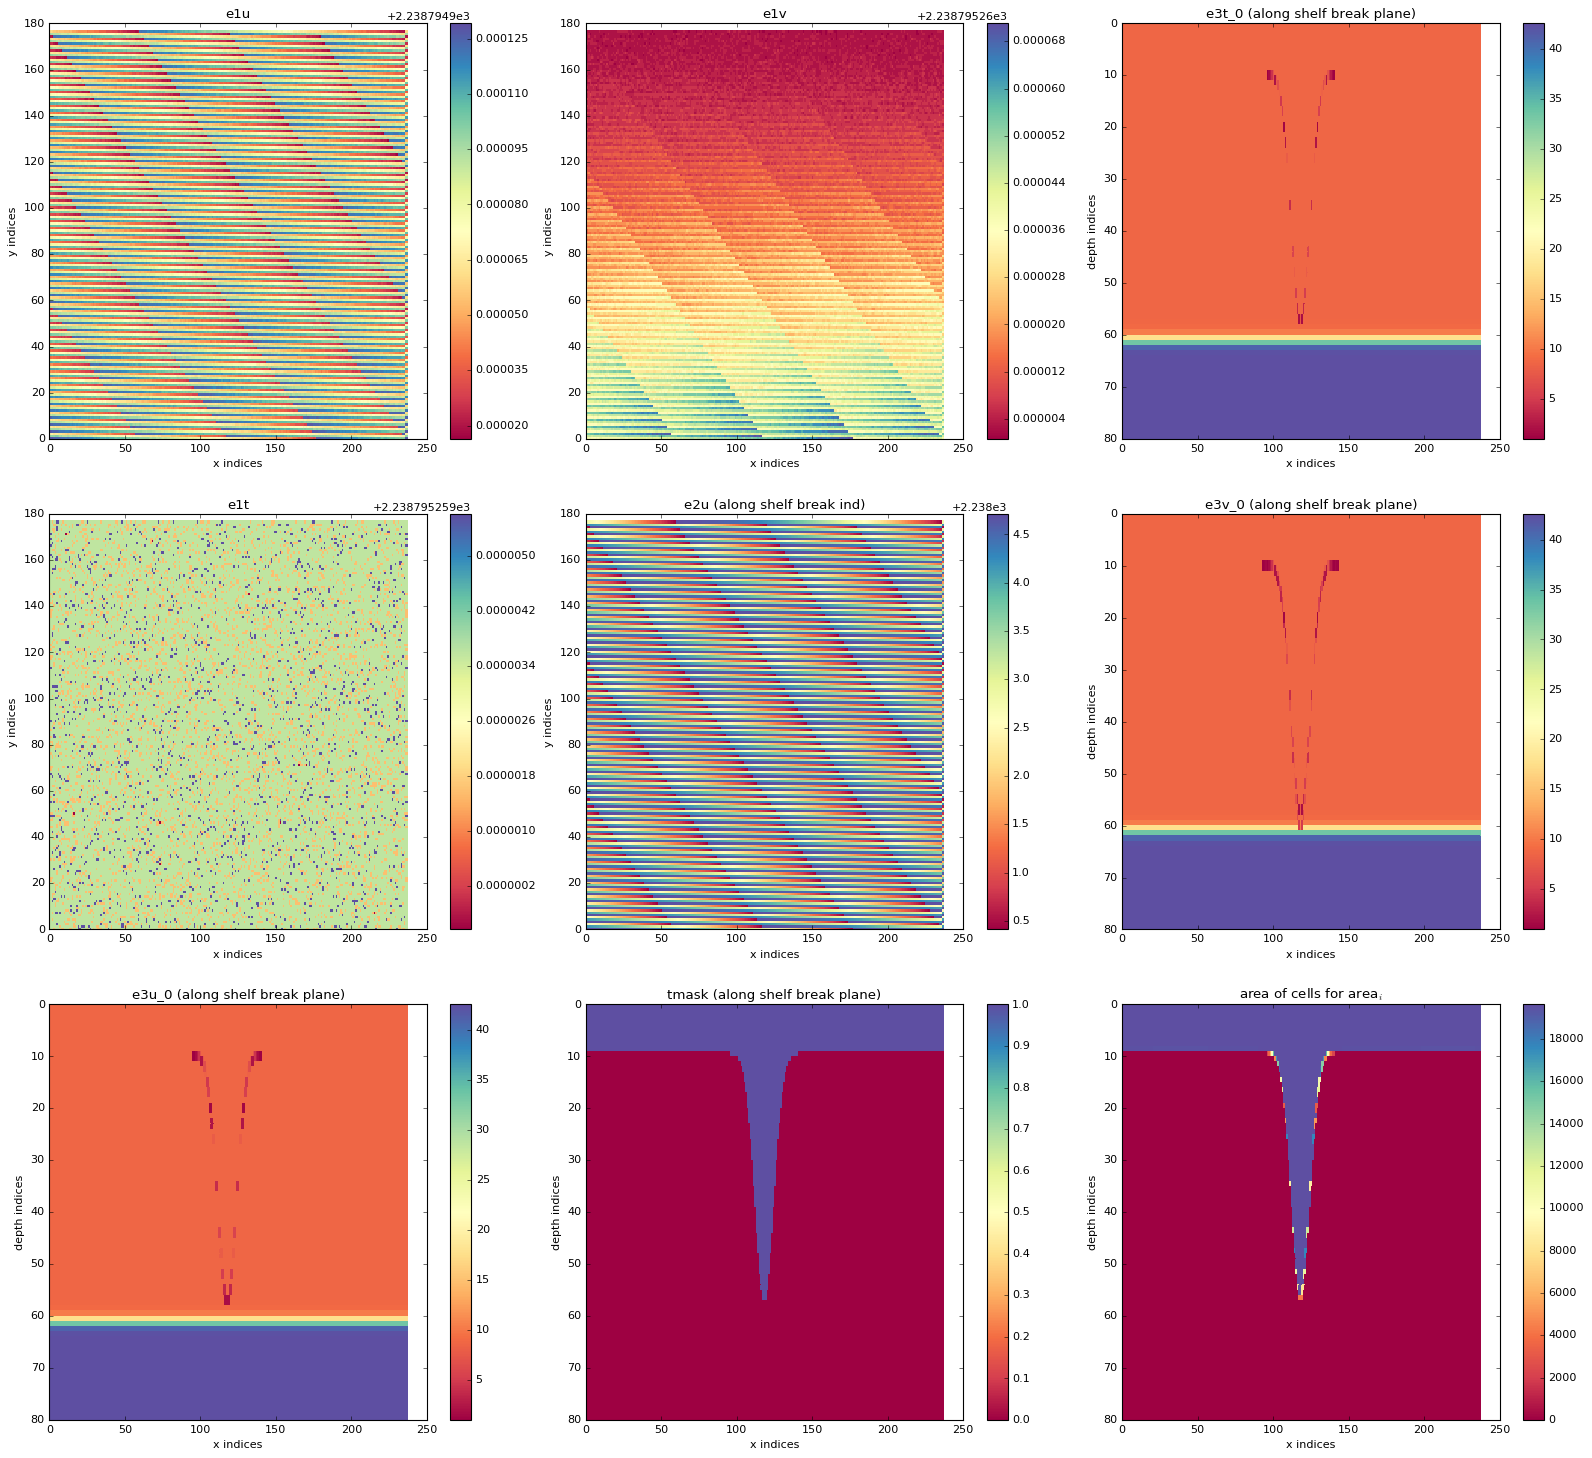

In [53]:
fig, ([ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9]) = plt.subplots(3,3, figsize=(20,18))
plt.tight_layout(h_pad=5, w_pad=3)
ax3.set_title('e3t_0 (along shelf break plane)')
ax3.set_ylabel('depth indices'); ax3.set_xlabel('x indices')
ax1.set_title('e1u')
ax1.set_ylabel('y indices'); ax1.set_xlabel('x indices')
ax2.set_title('e1v')
ax2.set_ylabel('y indices'); ax2.set_xlabel('x indices')
ax8.set_title('tmask (along shelf break plane)')
ax8.set_ylabel('depth indices'); ax8.set_xlabel('x indices')
ax4.set_title('e1t')
ax4.set_ylabel('y indices'); ax4.set_xlabel('x indices')
ax5.set_title('e2u (along shelf break ind)')
ax5.set_ylabel('y indices'); ax5.set_xlabel('x indices')
ax7.set_title('e3u_0 (along shelf break plane)')
ax7.set_ylabel('depth indices'); ax7.set_xlabel('x indices')
ax6.set_title('e3v_0 (along shelf break plane)')
ax6.set_ylabel('depth indices'); ax6.set_xlabel('x indices')
ax9.set_title('area of cells for area$_i$')
ax9.set_ylabel('depth indices'); ax9.set_xlabel('x indices')

p = ax1.pcolor(e1u[:,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax1)

p = ax2.pcolor(e1v[:,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax2)

p3 = ax3.pcolor(e3t_0[:,ind_plane,:], cmap=cm.Spectral)
fig.colorbar(p3, ax=ax3)
ax3.invert_yaxis()

p = ax4.pcolor(e1t[:,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax4)

p = ax5.pcolor(e2u, cmap=cm.Spectral)
fig.colorbar(p, ax=ax5)

p = ax6.pcolor(e3v_0[:,ind_plane,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax6)
ax6.invert_yaxis()

p = ax7.pcolor(e3u_0[:,ind_plane,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax7)
ax7.invert_yaxis()

p = ax8.pcolor(mask_plane, cmap=cm.Spectral)
fig.colorbar(p, ax=ax8)
ax8.invert_yaxis()

p = ax9.pcolor(area_i, cmap=cm.Spectral)
fig.colorbar(p, ax=ax9)
ax9.invert_yaxis()

# Horizontal Plane

In [ ]:
this_area = area_i # this is for horizontal plane

total area on plane: 56254331.9431
area above break depth: 41800245.0593
area in top half: 7348764.17816
area in bottom half: 7105322.70561


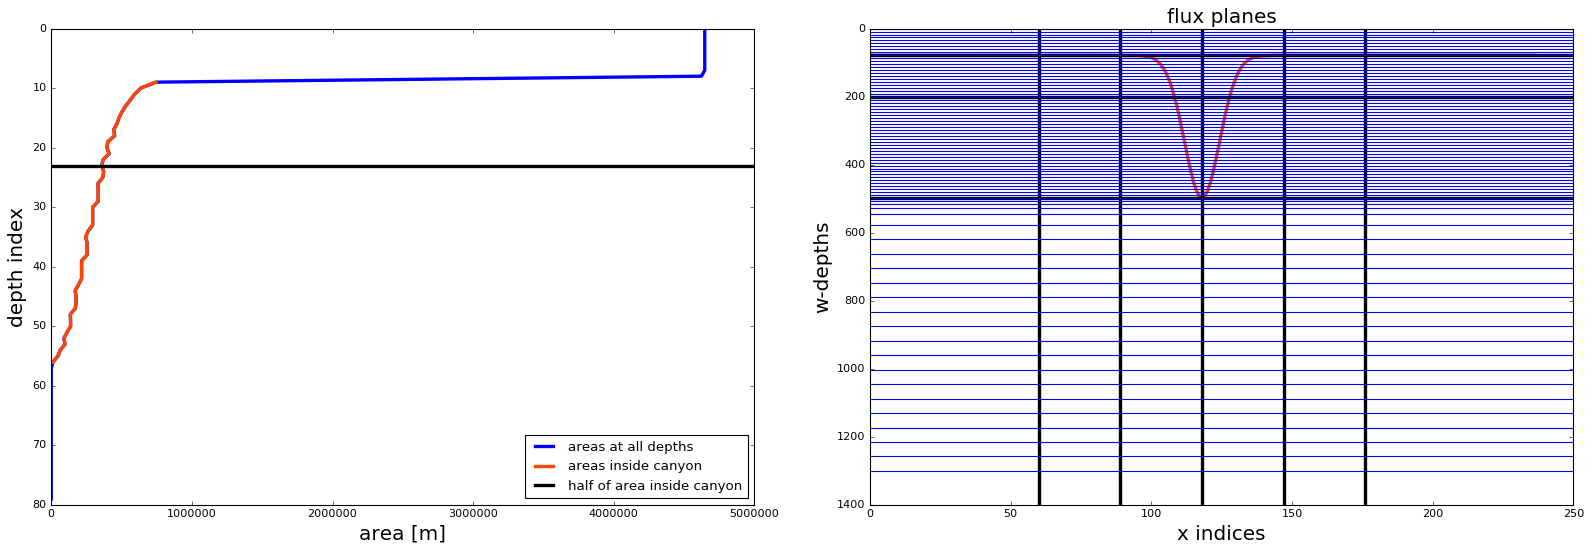

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
ax1.plot(area_all, np.arange(this_area.shape[0]), c='b', lw=3, label='areas at all depths')
ax1.plot(area_canyon, area_canyon_inds, c='orangered', lw=3, label='areas inside canyon')
ax1.axhline(ind_area_half, c='k', lw=3, label='half of area inside canyon')
ax1.invert_yaxis(); ax1.legend(loc=4)
ax1.set_ylabel('depth index', fontsize=18)
ax1.set_xlabel('area [m]', fontsize=18)

print('total area on plane:', sum_area_plane)
print('area above break depth:', sum_area_over_break)
print('area in top half:', sum_area_top_half)
print('area in bottom half:', sum_area_bot_half)

ax2.plot(bathy_plane, lw=3, c='orangered')
ax2.invert_yaxis()
ax2.axhline(depth_shelf, c=c, lw=lw)
ax2.axhline(depth_canyon, c=c, lw=lw)
ax2.axhline(depth_half, c=c, lw=lw)
ax2.axvline(ind_axis, c=c, lw=lw)
ax2.axvline(ind_rimL, c=c, lw=lw)
ax2.axvline(ind_rimR, c=c, lw=lw)
ax2.axvline(ind_shfL, c=c, lw=lw)
ax2.axvline(ind_shfR, c=c, lw=lw)
for gdepw in zip(gdepw_1d):
    ax2.axhline(gdepw, c='b', label = 'gdepw')
ax2.set_title('flux planes', fontsize=18)
ax2.set_ylabel('w-depths', fontsize=18)
ax2.set_xlabel('x indices', fontsize=18)
    
plt.tight_layout(h_pad=5, w_pad=3)

# Flux Basic
# $Q_j = v \times e1v \times e3v$

## and

# $Q_i = u \times e2u \times e3u$

In [39]:
with nc.Dataset(os.path.join(path, 'GYRE_1h_20170101_20170120_grid_U.nc'), 'r') as nbl:
    U_plane = nbl.variables['vozocrtx'][:, :, ind_plane, :]
    
with nc.Dataset(os.path.join(path, 'GYRE_1h_20170101_20170120_grid_V.nc'), 'r') as nbl:
    V_plane = nbl.variables['vomecrty'][:, :, ind_plane, :]

In [36]:
U_plane.shape, U_plane.shape, umask.shape

((480, 80, 237), (480, 80, 237), (80, 177, 237))

In [41]:
umask_plane = np.tile(1 - umask[:, ind_plane, :], (480, 1, 1))
U_masked = np.ma.array(U_plane, mask=umask_plane)

umask_plane.shape, U_masked.shape

((480, 80, 237), (480, 80, 237))

In [22]:
time_ind = 160
u = U_masked[time_ind, ...]
Qi = u * area_i

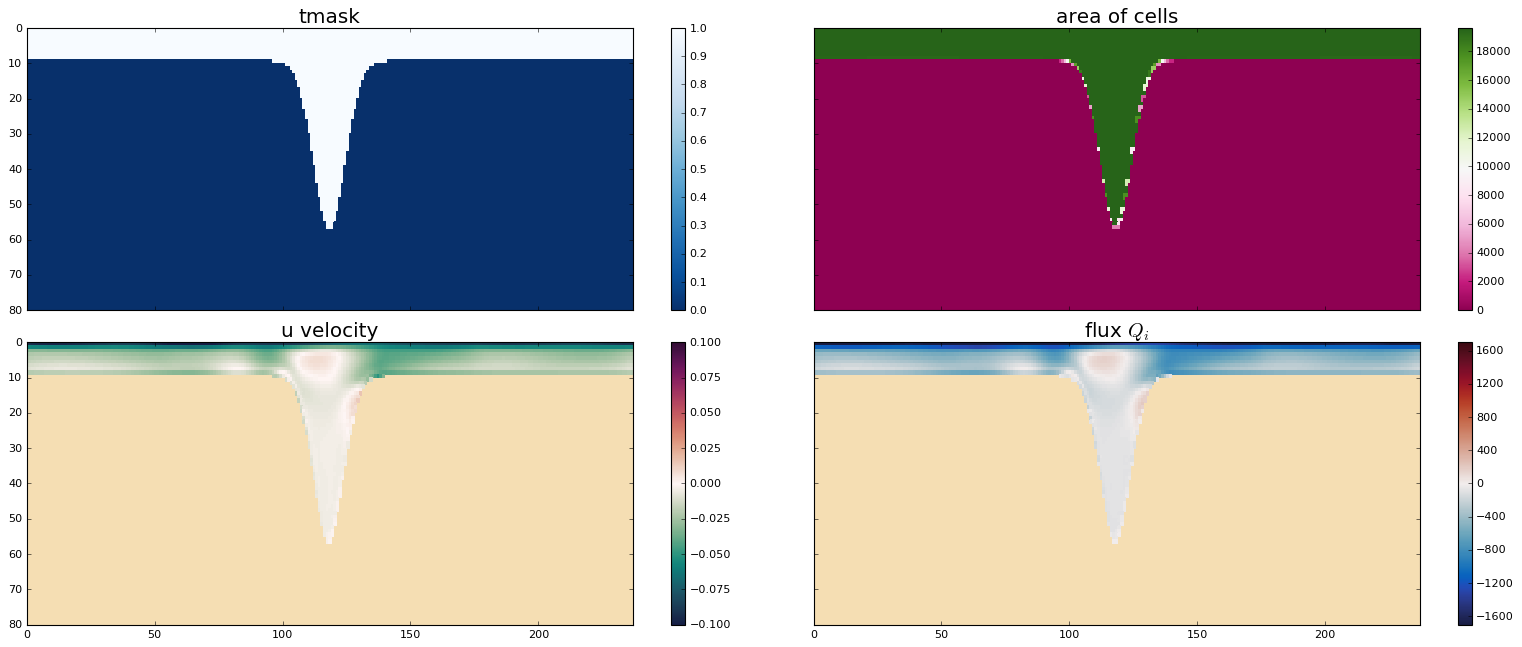

In [23]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2,figsize=(20,8), sharey=True, sharex=True)
plt.tight_layout(h_pad=2, w_pad=1)

p = ax1.pcolor(mask_plane, cmap=cm.Blues_r)
fig.colorbar(p, ax=ax1)
ax1.set_title('tmask', fontsize=18)

p = ax2.pcolor(area_i, cmap=cm.PiYG)
fig.colorbar(p, ax=ax2)
ax2.set_title('area of cells', fontsize=18)

p = ax3.pcolor(u, vmin=-0.1, vmax=0.1, cmap=cmo.cm.curl)
fig.colorbar(p, ax=ax3)
ax3.set_title('u velocity', fontsize=18)
ax3.set_axis_bgcolor('wheat')

p = ax4.pcolor(Qi, vmin=-1700, vmax=1700, cmap=cmo.cm.balance)
fig.colorbar(p, ax=ax4)
ax4.set_title('flux $Q_i$', fontsize=18)
ax4.set_axis_bgcolor('wheat')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim([mask_plane.shape[0], 0])
    ax.set_xlim([0, mask_plane.shape[1]])

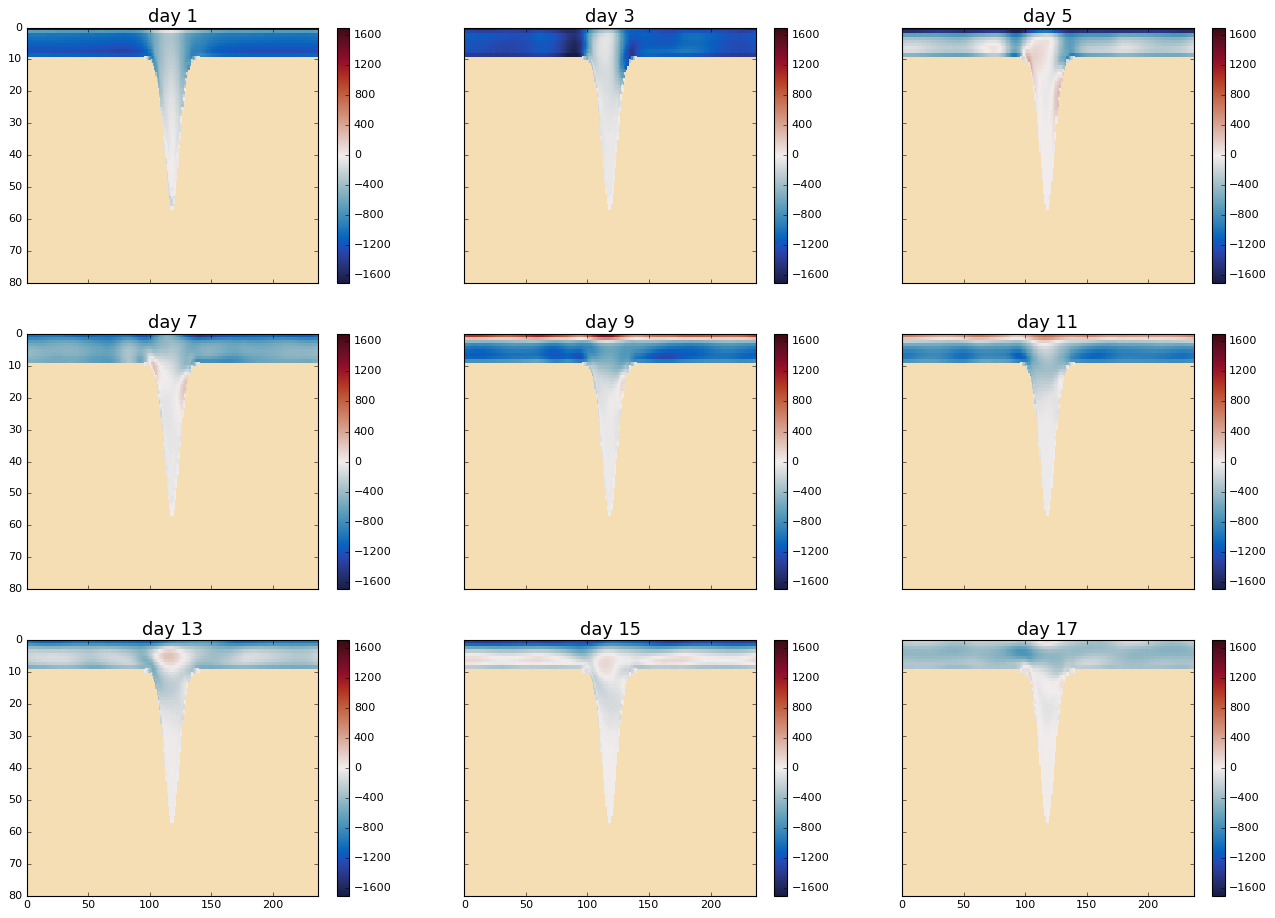

In [25]:
fig, ax = plt.subplots(3,3,figsize=(20, 14), sharex=True, sharey=True)
ax = ax.flatten()
time_inds = np.arange(1,18,2)*24
for n, time_ind in zip(np.arange(12), time_inds):
    u = U_masked[time_ind, ...]
    Qi = u * area_i
    p = ax[n].pcolor(Qi, vmin=-1700, vmax=1700, cmap=cmo.cm.balance)
    fig.colorbar(p, ax=ax[n])
    ax[n].set_axis_bgcolor('wheat')
    ax[n].set_title('day '+str(int(time_ind/24)), fontsize=16)
    ax[n].set_ylim([Qi.shape[0], 0])
    ax[n].set_xlim([0, Qi.shape[1]])

# Flux Through Planes

In [26]:
time_ind = 160
u = U_masked[time_ind, ...]
Qi = u * area_i

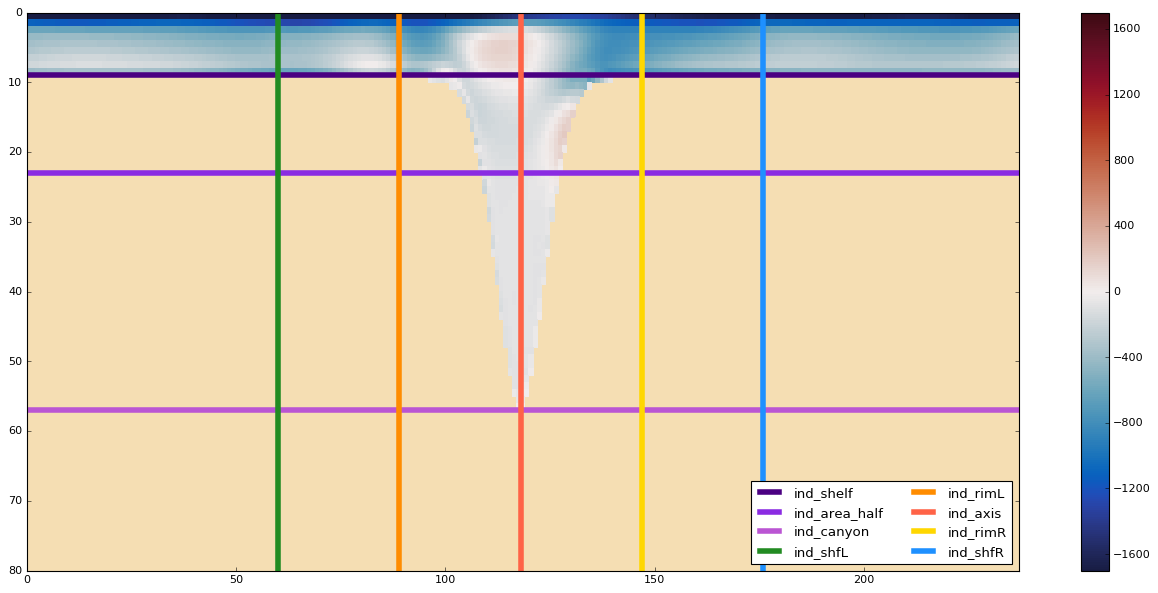

In [27]:
fig, ax = plt.subplots(1,1,figsize=(20,9)); lw=5
ax.axhline(ind_shelf, c='indigo', lw=lw, label='ind_shelf')
ax.axhline(ind_area_half, c='blueviolet', lw=lw, label='ind_area_half')
ax.axhline(ind_canyon, c='mediumorchid', lw=lw, label='ind_canyon')

ax.axvline(ind_shfL, c='forestgreen', lw=lw, label='ind_shfL')
ax.axvline(ind_rimL, c='darkorange', lw=lw, label='ind_rimL')
ax.axvline(ind_axis, c='tomato', lw=lw, label='ind_axis')
ax.axvline(ind_rimR, c='gold', lw=lw, label='ind_rimR')
ax.axvline(ind_shfR, c='dodgerblue', lw=lw, label='ind_shfR')

p = ax.pcolor(Qi, vmin=-1700, vmax=1700, cmap=cmo.cm.balance)
fig.colorbar(p, ax=ax)
ax.set_axis_bgcolor('wheat')
ax.set_xlim([0, Qi.shape[1]])
ax.invert_yaxis()
ax.legend(loc=4, ncol=2)

# Areas of Rectangles

In [28]:
def extract_plane_rectangles(variable):
    var_over_break_shfL = variable[:ind_shelf, ind_shfL:ind_rimL]
    var_over_break_rimL = variable[:ind_shelf, ind_rimL:ind_axis]
    var_over_break_rimR = variable[:ind_shelf, ind_axis:ind_rimR]
    var_over_break_shfR = variable[:ind_shelf, ind_rimR:ind_shfR]
    
    var_topL = variable[ind_shelf:ind_area_half+1, ind_rimL:ind_axis]
    var_topR = variable[ind_shelf:ind_area_half+1, ind_axis:ind_rimR]
    
    var_botL = variable[ind_area_half+1:, ind_rimL:ind_axis]
    var_botR = variable[ind_area_half+1:, ind_axis:ind_rimR]
    
    return var_over_break_shfL, var_over_break_rimL, var_over_break_rimR, var_over_break_shfR,\
            var_topL, var_topR, var_botL, var_botR
    
def total_variable_plane_rectangles(var_over_break_shfL, var_over_break_rimL, var_over_break_rimR, var_over_break_shfR, var_topL, var_topR, var_botL, var_botR):
    tot_var_over_break_shfL = np.sum(var_over_break_shfL)
    tot_var_over_break_rimL = np.sum(var_over_break_rimL)
    tot_var_over_break_rimR = np.sum(var_over_break_rimR)
    tot_var_over_break_shfR = np.sum(var_over_break_shfR)

    tot_var_topL = np.sum(var_topL)
    tot_var_topR = np.sum(var_topR)
    tot_var_botL = np.sum(var_botL)
    tot_var_botR = np.sum(var_botR)
    
    return tot_var_over_break_shfL, tot_var_over_break_rimL, tot_var_over_break_rimR, tot_var_over_break_shfR,\
            tot_var_topL, tot_var_topR, tot_var_botL, tot_var_botR

In [29]:
variable = area_i
area_over_break_shfL, area_over_break_rimL, area_over_break_rimR, area_over_break_shfR, area_topL, area_topR, area_botL, area_botR =  extract_plane_rectangles(variable)
tot_area_over_break_shfL, tot_area_over_break_rimL, tot_area_over_break_rimR, tot_area_over_break_shfR, tot_area_topL, tot_area_topR, tot_area_botL, tot_area_botR = total_variable_plane_rectangles(area_over_break_shfL, area_over_break_rimL, area_over_break_rimR, area_over_break_shfR, area_topL, area_topR, area_botL, area_botR)

In [30]:
print(tot_area_over_break_shfL, tot_area_over_break_rimL,tot_area_over_break_rimR, tot_area_over_break_shfR)
print(tot_area_topL, tot_area_topR, tot_area_botL, tot_area_botR)

#5117960.17966 5120945.16328 5119835.64006 5114633.95402
#3596604.57797 3752159.60019 3278326.69631 3826996.0093

5117960.17966 5120945.16328 5119835.64006 5114633.95402
3596604.57797 3752159.60019 3278326.69631 3826996.0093


# Flux of Rectangle

In [31]:
time_ind = 160
variable = U_masked[time_ind, ...]

u_over_break_shfL, u_over_break_rimL, u_over_break_rimR, u_over_break_shfR, u_topL, u_topR, u_botL, u_botR =  extract_plane_rectangles(variable)

In [32]:
Q_over_break_shfL = u_over_break_shfL * area_over_break_shfL
Q_over_break_rimL = u_over_break_rimL * area_over_break_rimL
Q_over_break_rimR = u_over_break_rimR * area_over_break_rimR
Q_over_break_shfR = u_over_break_shfR * area_over_break_shfR

Q_topL = u_topL * area_topL
Q_topR = u_topR * area_topR

Q_botL = u_botL * area_botL
Q_botR = u_botR *  area_botR

In [33]:
tot_Q_over_break_shfL, tot_Q_over_break_rimL, tot_Q_over_break_rimR, tot_Q_over_break_shfR, tot_Q_topL, tot_Q_topR, tot_Q_botL, tot_Q_botR = total_variable_plane_rectangles(Q_over_break_shfL, Q_over_break_rimL, Q_over_break_rimR, Q_over_break_shfR, Q_topL, Q_topR, Q_botL, Q_botR)

In [34]:
print(tot_Q_over_break_shfL, tot_Q_over_break_rimL, tot_Q_over_break_rimR, tot_Q_over_break_shfR)
print(tot_Q_topL, tot_Q_topR, tot_Q_botL, tot_Q_botR)

#-164264.337574 -123439.924359 -160966.884348 -199820.40783
#-20293.7348151 -19061.9156204 -14051.3408918 -11386.1913639

-164264.337574 -123439.924359 -160966.884348 -199820.40783
-20293.7348151 -19061.9156204 -14051.3408918 -11386.1913639
